In [ ]:
# Canonicar DS

## Imports

In [1]:
%%capture
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import shap as shap

## Device Configuration

In [2]:
# scikit-learn regression don't use GPU, may be good for other stuff
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Collection & Preprocessing

In [3]:
# df = pd.read_csv("Expanded_50000_noOutliers_Shuffled.csv")

In [4]:
# df

## smoothing data

In [5]:
# # Identify numeric columns for outlier removal
# numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# # Function to remove outliers using IQR
# def remove_outliers_iqr(dataframe, columns, k=1.5):
#     df_filtered = dataframe.copy()
#     for col in columns:
#         if col in df_filtered.columns:
#             Q1 = df_filtered[col].quantile(0.25)
#             Q3 = df_filtered[col].quantile(0.75)
#             IQR = Q3 - Q1
#             lower_bound = Q1 - k * IQR
#             upper_bound = Q3 + k * IQR
#             df_filtered = df_filtered[(df_filtered[col] >= lower_bound) &
#                                       (df_filtered[col] <= upper_bound)]
#     return df_filtered

# # Remove outliers
# df_no_outliers = remove_outliers_iqr(df, numeric_cols, k=1.5)

# # Function to smooth numeric values within the same vehicle category
# def smooth_vehicle_values(df, numeric_columns, epsilon=0.02):
#     df_smoothed = df.copy()
#     grouped = df_smoothed.groupby('vehicle_name')

#     for col in numeric_columns:
#         if col in df_smoothed.columns:
#             mean_values = grouped[col].transform('mean')
#             variation = np.random.uniform(-epsilon, epsilon, size=len(df_smoothed))
#             df_smoothed[col] = mean_values * (1 + variation)

#     return df_smoothed

# # Apply smoothing to numerical values within each vehicle category
# df = smooth_vehicle_values(df_no_outliers, numeric_cols, epsilon=0.02)

# # Save the final processed dataset
# output_file_path = "Final_Cleaned_Smoothed_Dataset.xlsx"
# df.to_excel(output_file_path, index=False)

In [19]:
df = pd.read_excel("Smoothed_Dataset.xlsx")

In [20]:
df.head()

,vehicle_name,vehicle_type,track_type,average_speed,fuel_consumption,total_steering,total_throttle,total_brake,velocity,lap time,...,front_left_wheel_max_brake_torque,front_left_wheel_lat_stiff_max_load,front_left_wheel_lat_stiff_value,front_left_wheel_long_stiff_value,rear_right_wheel_radius,rear_right_wheel_max_brake_torque,rear_right_wheel_max_handbrake_torque,rear_right_wheel_lat_stiff_max_load,rear_right_wheel_lat_stiff_value,rear_right_wheel_long_stiff_value
0,vehicle.volkswagen.t2_2021,Van,easy,16.672509,0.009887,279.977420,69.871542,10.618988,5.104502,58.763348,...,399.673360,2.008777,16.852462,1002.624975,32.916001,401.968157,785.467210,2.009718,17.197560,985.636358
1,vehicle.kawasaki.ninja,Motorcycle,easy,16.409794,0.011054,291.607164,79.909894,11.402934,4.991332,56.330482,...,1513.306097,1.972909,16.847481,982.086904,32.591322,1524.259251,3044.449795,2.034650,17.228331,1005.993149
2,vehicle.dodge.charger_2020,Car,easy,16.952606,0.011811,275.762615,76.237177,8.019897,4.972129,60.752564,...,1016.476448,3.057575,19.600114,3045.201167,34.860914,997.875551,1969.301720,3.024882,20.268299,3022.803183
3,vehicle.lincoln.mkz_2020,Car,easy,16.987731,0.010284,266.239469,83.565008,11.508604,4.880582,58.508800,...,815.901111,2.985979,20.147366,3055.209314,35.831930,808.127860,1627.824250,3.026204,20.076663,3013.331433
4,vehicle.mini.cooper_s_2021,Car,hard,16.633896,0.010692,267.976682,81.483089,8.525353,5.003280,57.716317,...,504.302450,1.000400,16.798289,3000.563196,37.165484,505.639057,992.191584,1.003060,16.899603,2996.019069


In [22]:
# Potentially useful numeric features (verify these columns exist in your data)
numeric_features = [
    "average_speed",
    # 'fuel_consumption',
    # 'total_steering',
    "total_throttle",
    # 'total_brake',
    "velocity",
    "mass",
    # 'drag_coefficient',
    # 'center_of_mass_x',
    # 'max_rpm',
    "clutch_strength",
    # 'gear_switch_time',
    # 'front_left_wheel_radius',
    # 'front_left_wheel_max_brake_torque',
    "front_left_wheel_lat_stiff_max_load",
    "front_left_wheel_lat_stiff_value",
    "front_left_wheel_long_stiff_value",
    # 'rear_right_wheel_radius',
    # 'rear_right_wheel_max_brake_torque',
    # 'rear_right_wheel_max_handbrake_torque',
    "rear_right_wheel_lat_stiff_max_load",
    "rear_right_wheel_lat_stiff_value",
    "rear_right_wheel_long_stiff_value",
]

# # Define the favorite features
# numeric_features = [
#     'average_speed', 'total_steering', 'total_throttle', 'total_brake']

categorical_features = ["vehicle_type", "track_type"]

favorite_features = numeric_features + categorical_features

# Target variable
target = "lap time"

# Check if the columns exist in the DataFrame
missing_columns = [col for col in favorite_features + [target] if col not in df.columns]
if missing_columns:
    raise ValueError(
        f"The following columns are missing from the DataFrame: {missing_columns}"
    )

# Subset the DataFrame
df_subset = df[favorite_features + [target]].dropna()

# Inspect the shape
print("Data subset shape:", df_subset.shape)
print("Features:", favorite_features)
print("Target:", target)

Data subset shape: (21402, 14)
Features: ['average_speed', 'total_throttle', 'velocity', 'mass', 'clutch_strength', 'front_left_wheel_lat_stiff_max_load', 'front_left_wheel_lat_stiff_value', 'front_left_wheel_long_stiff_value', 'rear_right_wheel_lat_stiff_max_load', 'rear_right_wheel_lat_stiff_value', 'rear_right_wheel_long_stiff_value', 'vehicle_type', 'track_type']
Target: lap time


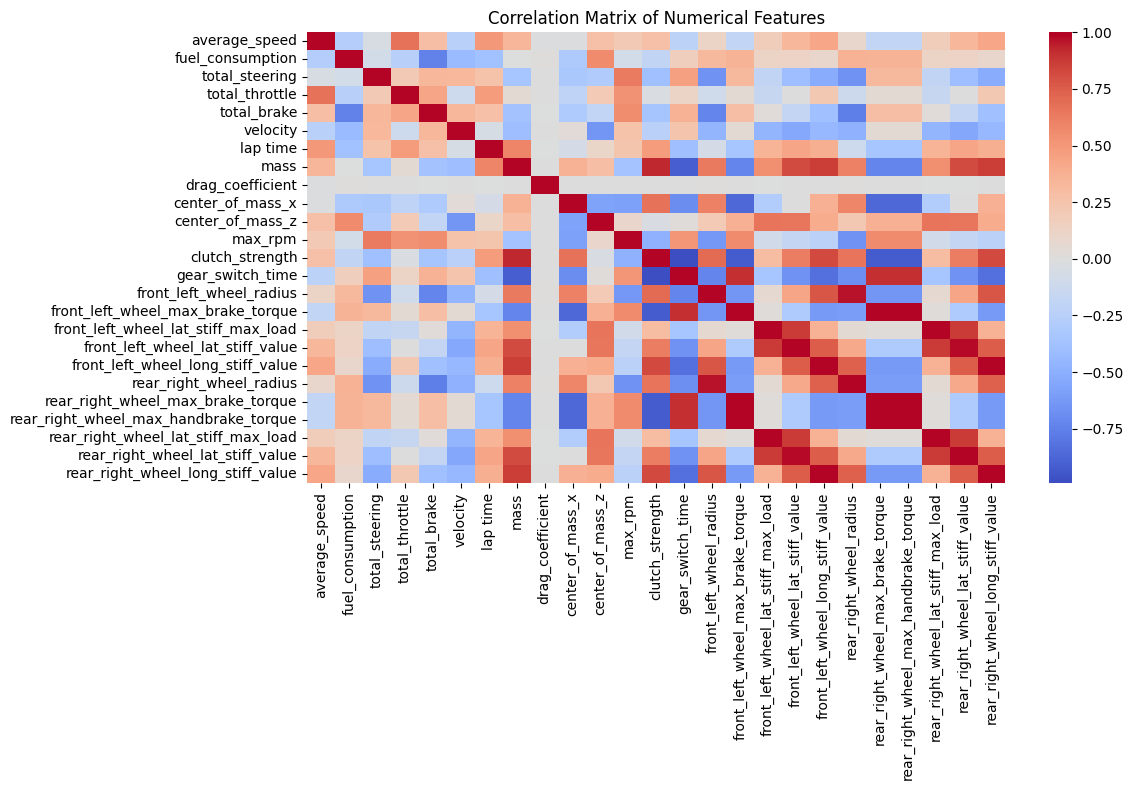


Correlation with lap time:
mass                                   0.593569
average_speed                          0.500120
total_throttle                         0.485358
clutch_strength                        0.481651
front_left_wheel_lat_stiff_value       0.437453
rear_right_wheel_lat_stiff_value       0.435566
front_left_wheel_long_stiff_value      0.384511
rear_right_wheel_long_stiff_value      0.384309
front_left_wheel_lat_stiff_max_load    0.352776
rear_right_wheel_lat_stiff_max_load    0.352434
Name: lap time, dtype: float64


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

targets = ["lap time"]

if "targets" not in locals() and "targets" not in globals():
    raise ValueError(
        "The variable 'targets' is not defined. Please define it as a list of target column names."
    )

numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns

valid_targets = [t for t in targets if t in numerical_cols]
if not valid_targets:
    raise ValueError(
        f"None of the target columns {targets} are numeric or present in the DataFrame."
    )

corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

for target in valid_targets:
    print(f"\nCorrelation with {target}:")
    correlations = df[numerical_cols].corr()[target].sort_values(ascending=False)
    print(correlations[correlations.index != target].head(10))

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define the transformers
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]
)

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)

# Separate features and target
X = df_subset.drop(columns=[target])
y = df_subset[target]

# Fit and transform the features
X_transformed = preprocessor.fit_transform(X)

# Get feature names after one-hot encoding
cat_onehot_feature_names = (
    preprocessor.named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names_out(categorical_features)
)
all_feature_names = numeric_features + list(cat_onehot_feature_names)

# Create a DataFrame with the transformed features
X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

print("Transformed DataFrame Shape:", X_transformed_df.shape)
print("all_feature_names:", all_feature_names)

Transformed DataFrame Shape: (21402, 16)
all_feature_names: ['average_speed', 'total_throttle', 'velocity', 'mass', 'clutch_strength', 'front_left_wheel_lat_stiff_max_load', 'front_left_wheel_lat_stiff_value', 'front_left_wheel_long_stiff_value', 'rear_right_wheel_lat_stiff_max_load', 'rear_right_wheel_lat_stiff_value', 'rear_right_wheel_long_stiff_value', 'vehicle_type_Car', 'vehicle_type_Motorcycle', 'vehicle_type_Van', 'track_type_easy', 'track_type_hard']


In [25]:
X_transformed_df

,average_speed,total_throttle,velocity,mass,clutch_strength,front_left_wheel_lat_stiff_max_load,front_left_wheel_lat_stiff_value,front_left_wheel_long_stiff_value,rear_right_wheel_lat_stiff_max_load,rear_right_wheel_lat_stiff_value,rear_right_wheel_long_stiff_value,vehicle_type_Car,vehicle_type_Motorcycle,vehicle_type_Van,track_type_easy,track_type_hard
0,-0.256302,-1.080515,1.830678,0.231494,0.798095,-0.361045,-0.877225,-1.019582,-0.359174,-0.639164,-1.036394,0.0,0.0,1.0,1.0,0.0
1,-1.116122,0.593524,0.698830,-1.198938,-1.239871,-0.414586,-0.880606,-1.040122,-0.321955,-0.618290,-1.016038,0.0,1.0,0.0,1.0,0.0
2,0.660409,-0.018954,0.506768,1.459863,0.833514,1.204529,0.987707,1.023223,1.156351,1.443953,1.000768,1.0,0.0,0.0,1.0,0.0
3,0.775367,1.203067,-0.408820,1.114443,0.832865,1.097656,1.359147,1.033232,1.158326,1.313952,0.991296,1.0,0.0,0.0,1.0,0.0
4,-0.382675,0.855877,0.818321,0.232614,0.772154,-1.866282,-0.913995,0.978580,-1.862002,-0.841291,0.973984,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21397,-1.186932,-1.012042,-0.753734,-1.014447,-1.241236,-0.362927,-0.675480,-1.002227,-0.391696,-0.558438,-1.011396,0.0,1.0,0.0,0.0,1.0
21398,-0.565799,1.108918,1.230646,0.219336,0.826265,-1.885898,-0.583640,0.998384,-1.879919,-0.841711,0.988565,1.0,0.0,0.0,1.0,0.0
21399,-0.091070,-1.075265,0.333115,0.236132,0.834242,-0.406087,-0.803728,-1.027572,-0.394993,-0.943247,-1.019354,0.0,0.0,1.0,1.0,0.0
21400,-0.009524,0.618993,0.096712,0.259229,0.767388,-1.842684,-0.989959,0.984415,-1.878146,-0.913408,0.957905,1.0,0.0,0.0,0.0,1.0


#### Train-test split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed_df, y, test_size=0.2, random_state=42
)

In [27]:
X_train

,average_speed,total_throttle,velocity,mass,clutch_strength,front_left_wheel_lat_stiff_max_load,front_left_wheel_lat_stiff_value,front_left_wheel_long_stiff_value,rear_right_wheel_lat_stiff_max_load,rear_right_wheel_lat_stiff_value,rear_right_wheel_long_stiff_value,vehicle_type_Car,vehicle_type_Motorcycle,vehicle_type_Van,track_type_easy,track_type_hard
18971,-0.321731,-0.681262,-1.038166,-1.011936,-1.243069,-0.431376,-0.564869,-1.014896,-0.324331,-0.709326,-1.015539,0.0,1.0,0.0,1.0,0.0
8246,-1.367040,-0.543238,0.306824,-1.015251,-1.242011,-0.327790,-0.927986,-1.015151,-0.372421,-0.872734,-1.008904,0.0,1.0,0.0,1.0,0.0
1959,-0.818846,-1.487417,0.423167,0.180614,0.814210,-0.350691,-0.971095,-1.036678,-0.343288,-0.935144,-1.004735,0.0,0.0,1.0,1.0,0.0
14897,0.852373,0.671146,2.112270,-1.242426,-1.242914,-0.401547,-0.608156,-1.005792,-0.423139,-0.661245,-1.017505,0.0,1.0,0.0,1.0,0.0
14625,-0.181812,-0.611399,-0.919378,-1.014825,-1.239641,-0.332174,-0.753370,-1.036183,-0.330129,-0.680572,-1.005940,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.181131,0.517533,0.020242,-1.204584,-1.239160,-0.416604,-0.557145,-1.033135,-0.419318,-0.556276,-1.012984,0.0,1.0,0.0,1.0,0.0
11964,-1.528838,-1.778823,-1.056205,0.648902,0.826458,1.192365,1.510091,0.935836,1.160418,1.442691,1.034539,1.0,0.0,0.0,1.0,0.0
5390,0.798852,1.498464,-1.359273,1.085603,0.765599,1.139308,1.389329,0.947574,1.114181,1.210619,0.998880,1.0,0.0,0.0,0.0,1.0
860,0.069773,-1.186997,1.736848,0.211911,0.769742,-0.383352,-0.683107,-1.036194,-0.429360,-0.790661,-1.034636,0.0,0.0,1.0,1.0,0.0


### Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression

#### Fit models and compute MSE, RMSE, R² scores

In [29]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MSE: {mse_lr:.2f}, R²: {r2_lr:.3f}")

Linear Regression - MSE: 0.66, R²: 0.808


#### Visualize plots

#### Feature importance ranking

### Gaussian Process

In [43]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_absolute_error, mean_squared_error

The model uses a Radial Basis Function (RBF) kernel, which allows it to capture nonlinear relationships.

The ConstantKernel defines the scale of variation.

#### Fit models and compute MSE, RMSE, R² scores

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


# Gaussian Process Regression
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(X_train, y_train)
y_pred_gpr = gpr.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_gpr):.2f}")

#### Visualize plots

#### Feature importance ranking

### DecisionTreeRegressor

In [39]:
from sklearn.tree import DecisionTreeRegressor

#### Fit models and compute MSE, RMSE, R² scores

In [ ]:
# Decision Tree Regressor with best params
dt = DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print(f"Decision Tree Regression - MSE: {mse_dt}, R²: {r2_dt}")

Decision Tree Regression - MSE: 0.5013333805355157, R²: 0.8550214067013804


#### Visualize plots

#### Feature importance ranking

### Random Forest

In [31]:
from sklearn.ensemble import RandomForestRegressor

#### Fit models and compute MSE, RMSE, R² scores

In [ ]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=120, max_depth=6, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regression - MSE: {mse_rf}, R²: {r2_rf}")

Random Forest Regression - MSE: 0.44109910256107715, R²: 0.8724403164092558


#### Visualize plots

#### Feature importance ranking

### Gradient Boosting

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

#### Fit models and compute MSE, RMSE, R² scores

In [ ]:
# Gradient Boosting Regressor with best params
gb = GradientBoostingRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=9, random_state=42
)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting Regression - MSE: {mse_gb}, R²: {r2_gb}")

Gradient Boosting Regression - MSE: 0.47137172050365433, R²: 0.8636858992186565


#### Visualize plots

#### Feature importance ranking

### Support Vector

In [37]:
from sklearn.svm import SVR

#### Fit models and compute MSE, RMSE, R² scores

In [ ]:
svr = SVR(kernel="rbf", C=10, epsilon=0.1)
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f"SVR - MSE: {mse_svr}, R²: {r2_svr}")

SVR - MSE: 0.4536592661358397, R²: 0.8688080929879378


#### Visualize plots

In [41]:
# Code Block 6 - Model Comparison

models_results = {
    "LinearRegression": {"MSE": mse_lr, "R2": r2_lr},
    "DecisionTree": {"MSE": mse_dt, "R2": r2_dt},
    "RandomForest": {"MSE": mse_rf, "R2": r2_rf},
    "GradientBoosting": {"MSE": mse_gb, "R2": r2_gb},
    "SVR": {"MSE": mse_svr, "R2": r2_svr},
}

for model, metrics in models_results.items():
    print(f"{model} -> MSE: {metrics['MSE']:.2f}, R^2: {metrics['R2']:.3f}")

LinearRegression -> MSE: 0.66, R^2: 0.808
DecisionTree -> MSE: 0.50, R^2: 0.855
RandomForest -> MSE: 0.44, R^2: 0.872
GradientBoosting -> MSE: 0.47, R^2: 0.864
SVR -> MSE: 0.45, R^2: 0.869


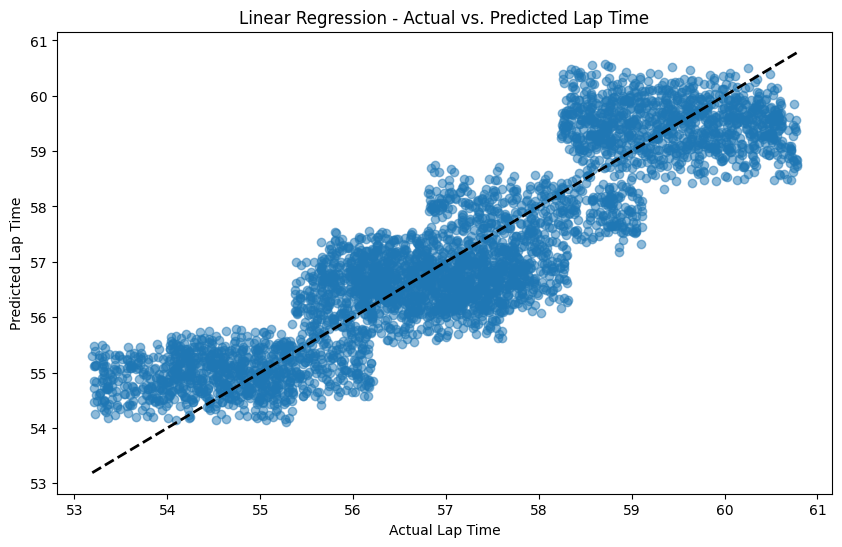

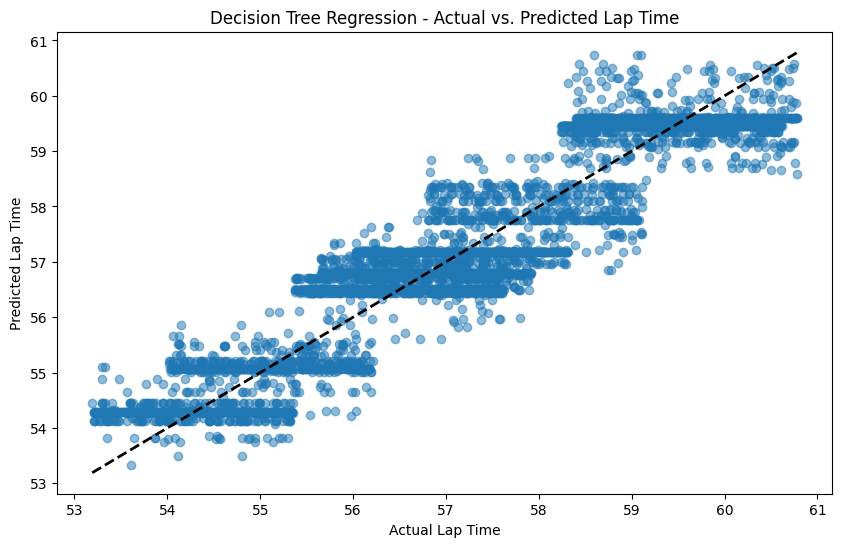

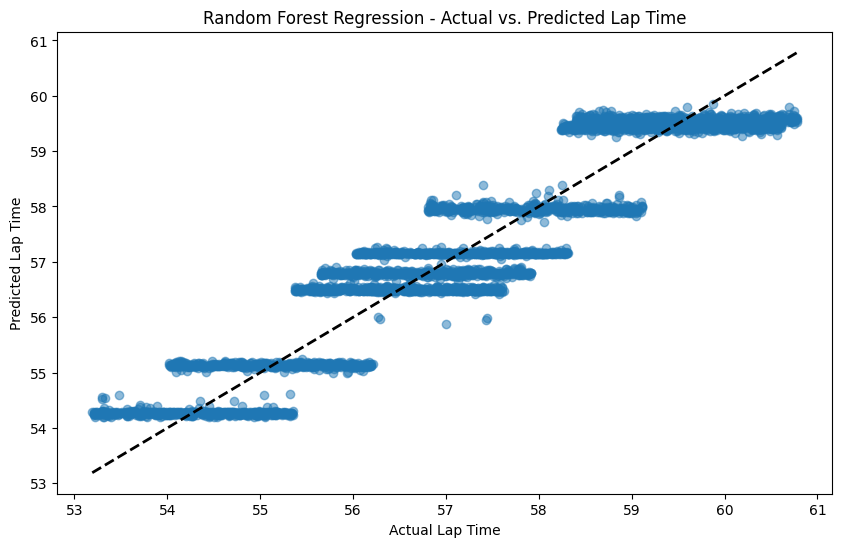

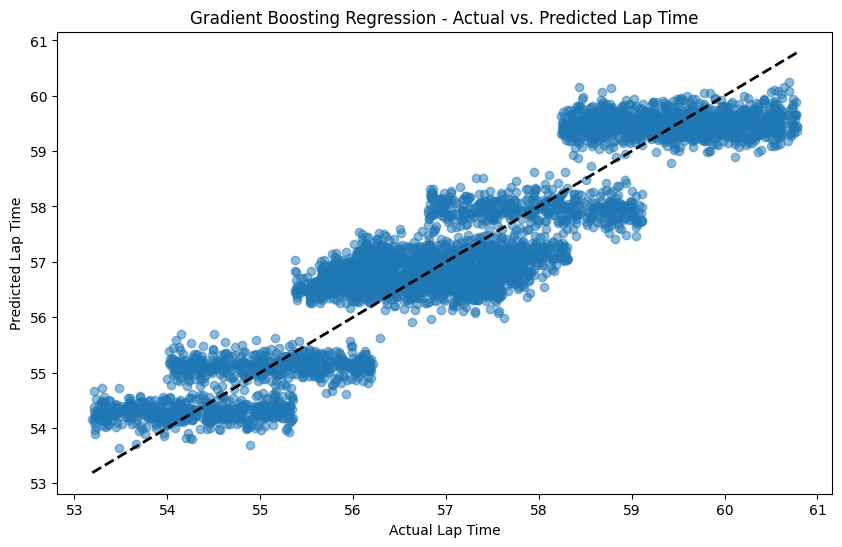

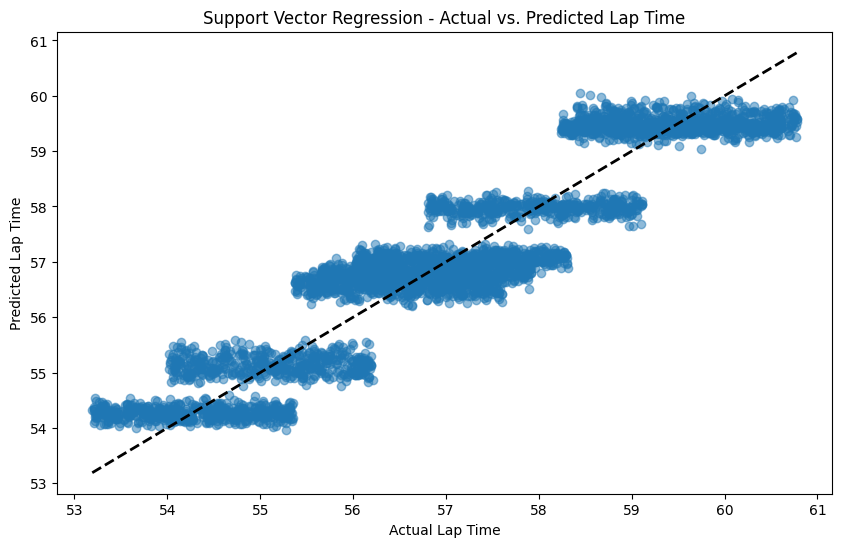

NameError: name 'y_pred_gpr' is not defined

In [42]:
# Function to plot actual vs. predicted lap times
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
    plt.xlabel("Actual Lap Time")
    plt.ylabel("Predicted Lap Time")
    plt.title(title)
    plt.show()


# Linear Regression
plot_actual_vs_predicted(
    y_test, y_pred_lr, "Linear Regression - Actual vs. Predicted Lap Time"
)

# Decision Tree Regression
plot_actual_vs_predicted(
    y_test, y_pred_dt, "Decision Tree Regression - Actual vs. Predicted Lap Time"
)

# Random Forest Regression
plot_actual_vs_predicted(
    y_test, y_pred_rf, "Random Forest Regression - Actual vs. Predicted Lap Time"
)

# Gradient Boosting Regression
plot_actual_vs_predicted(
    y_test, y_pred_gb, "Gradient Boosting Regression - Actual vs. Predicted Lap Time"
)

# Support Vector Regression
plot_actual_vs_predicted(
    y_test, y_pred_svr, "Support Vector Regression - Actual vs. Predicted Lap Time"
)

# Gaussian Process Regression
plot_actual_vs_predicted(
    y_test, y_pred_gpr, "Gaussian Process Regression - Actual vs. Predicted Lap Time"
)

In [ ]:
all

##  Neural Networks for Regression

### Completion Time Prediction
- MLP
- **Activation**: ReLU, Tanh.
- **Loss Function**: MSE.

In [ ]:
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_lap, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_lap, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(
    y_train_lap.values.reshape(-1, 1), dtype=torch.float32
).to(device)
y_test_tensor = torch.tensor(y_test_lap.values.reshape(-1, 1), dtype=torch.float32).to(
    device
)

device

#### Network

In [ ]:
import torch.nn as nn


class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 8)
        self.fc9 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.batch_norm4 = nn.BatchNorm1d(128)
        self.batch_norm5 = nn.BatchNorm1d(64)
        self.batch_norm6 = nn.BatchNorm1d(32)
        self.batch_norm7 = nn.BatchNorm1d(16)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.relu(self.batch_norm3(self.fc3(x)))
        x = self.relu(self.batch_norm4(self.fc4(x)))
        x = self.relu(self.batch_norm5(self.fc5(x)))
        x = self.relu(self.batch_norm6(self.fc6(x)))
        x = self.relu(self.batch_norm7(self.fc7(x)))
        x = self.fc8(x)
        x = self.fc9(x)  # No activation for regression
        return x


# Initialize model
input_dim = X_train_tensor.shape[1]
model = RegressionNN(input_dim).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

#### Train

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Training Loop
epochs = 500
losses = []
r2_scores = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Store loss and R² score
    losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train_tensor)
        train_r2 = r2_score(
            y_train_tensor.cpu().numpy(), train_predictions.cpu().numpy()
        )
        r2_scores.append(train_r2)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, R² Score: {train_r2:.4f}"
        )

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, R² Score: {train_r2:.4f}")

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    test_r2 = r2_score(y_test_tensor.cpu().numpy(), test_predictions.cpu().numpy())

print(f"Test Loss: {test_loss.item():.4f}, Test R² Score: {test_r2:.4f}")

# Plotting Loss and R² Score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(r2_scores, label="R² Score", color="orange")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Training R² Score")
plt.legend()

plt.tight_layout()
plt.show()

#### Test & Evaluate

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).cpu().numpy()
    y_pred_test = model(X_test_tensor).cpu().numpy()

# Compute metrics
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")

### Stability Prediction
  - Combination of speed, acceleration, and tire pressure as inputs.
  - Embedding layer for vehicle type (categorical feature).

#### Network

#### Train

#### Test & Evaluate

## Classification - PySpark

### Decision Tree

#### Train

#### Test & Evaluate
 - **Accuracy, Precision, Recall, F1-score**.

#### Plots
 - **Confusion Matrix & ROC Curves**.

### Naive Bayes

#### Train

#### Test & Evaluate
 - **Accuracy, Precision, Recall, F1-score**.

#### Plots
 - **Confusion Matrix & ROC Curves**.

### XGBoost

#### Train

#### Test & Evaluate
 - **Accuracy, Precision, Recall, F1-score**.

#### Plots
 - **Confusion Matrix & ROC Curves**.

### Random Forest

#### Train

#### Test & Evaluate
 - **Accuracy, Precision, Recall, F1-score**.

#### Plots
 - **Confusion Matrix & ROC Curves**.

## Clustering - PySpark
- Grouping Similar Driving Behaviors

### Evaluation & Visualization

#### Silhouette Score
- To measure clustering quality

#### PCA / t-SNE Plots
- Visualize clusters in 2D/3D